<a href="https://colab.research.google.com/github/canon14/MovieRecommendationModel/blob/main/TMDBMovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from scipy.stats import gaussian_kde

%matplotlib inline

In [ ]:
tmdb_attributes_df = pd.read_csv('/content/tmdb_attributes.csv')
tmdb_genres_df = pd.read_csv('/content/tmdb_genres.csv')
tmdb_keywords_df = pd.read_csv('/content/tmdb_keywords.csv')
tmdb_overview_keywords_df = pd.read_csv('/content/tmdb_overview_keywords.csv')

##Data Cleaning, Transformation, and Exploration

In [ ]:
#Create separate dataframes to group genres (genre count and lists)
#Genre Count
genre_count_df = tmdb_genres_df.groupby(['title', 'movieID'],as_index=False).count().rename(columns={'genre' : 'genre_counts'})
genre_count_df = genre_count_df.drop('Unnamed: 0', axis=1)

#Group Genre into lists 
genre_lists_df = tmdb_genres_df.groupby(['title', 'movieID'])['genre'].apply(list).reset_index(name='genres')

In [ ]:
#Join all the created dataframes into tmdb_attributes
genre_count_lists_df = genre_lists_df.merge(genre_count_df, how='inner', on=['title', 'movieID'])

tmdb_attributes_df = tmdb_attributes_df.merge(genre_count_lists_df, how='inner', left_on='id', right_on='movieID')

#rename and drop columns
tmdb_attributes_df = tmdb_attributes_df.drop(['title_x', 'title_y', 'movieID'], axis=1).rename(columns={'id': 'movie_id', 'original_title':'title'})

#create a new column to store genres information in string and not list
tmdb_attributes_df['genre_string'] = [', '.join(map(str, l)) for l in tmdb_attributes_df['genres']]

#fill empty value for runtime with the mean (since we only have 2 missing values)
tmdb_attributes_df['runtime'] = tmdb_attributes_df['runtime'].fillna(tmdb_attributes_df['runtime'].mean())

# changing the release_date format
tmdb_attributes_df['release_date'] = pd.to_datetime(tmdb_attributes_df['release_date'])

In [ ]:
tmdb_attributes_df

,budget,movie_id,original_language,title,popularity,release_date,revenue,runtime,tagline,vote_average,vote_count,genres,genre_counts,genre_string
0,237000000,19995,en,Avatar,150.437577,12/10/09,2787965087,162.0,Enter the World of Pandora.,7.2,11800,"[Action, Adventure, Fantasy, SciFi]",4,"Action, Adventure, Fantasy, SciFi"
1,300000000,285,en,Pirates of the Caribbean: At World's End,139.082615,5/19/07,961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,"[Adventure, Fantasy, Action]",3,"Adventure, Fantasy, Action"
2,245000000,206647,en,Spectre,107.376788,10/26/15,880674609,148.0,A Plan No One Escapes,6.3,4466,"[Action, Adventure, Crime]",3,"Action, Adventure, Crime"
3,250000000,49026,en,The Dark Knight Rises,112.312950,7/16/12,1084939099,165.0,The Legend Ends,7.6,9106,"[Action, Crime, Drama, Thriller]",4,"Action, Crime, Drama, Thriller"
4,260000000,49529,en,John Carter,43.926995,3/7/12,284139100,132.0,"Lost in our world, found in another.",6.1,2124,"[Action, Adventure, SciFi]",3,"Action, Adventure, SciFi"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,0,67238,en,Cavite,0.022173,3/12/05,0,80.0,NaN,7.5,2,"[Foreign, Thriller]",2,"Foreign, Thriller"
4771,220000,9367,es,El Mariachi,14.269792,9/4/92,2040920,81.0,"He didn't come looking for trouble, but troubl...",6.6,238,"[Action, Crime, Thriller]",3,"Action, Crime, Thriller"
4772,9000,72766,en,Newlyweds,0.642552,12/26/11,0,85.0,A newlywed couple's honeymoon is upended by th...,5.9,5,"[Comedy, Romance]",2,"Comedy, Romance"
4773,0,231617,en,"Signed, Sealed, Delivered",1.444476,10/13/13,0,120.0,NaN,7.0,6,"[Comedy, Drama, Romance, TV Movie]",4,"Comedy, Drama, Romance, TV Movie"


In [ ]:
tmdb_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4775 entries, 0 to 4774
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             4775 non-null   int64  
 1   movie_id           4775 non-null   int64  
 2   original_language  4775 non-null   object 
 3   title              4775 non-null   object 
 4   popularity         4775 non-null   float64
 5   release_date       4775 non-null   object 
 6   revenue            4775 non-null   int64  
 7   runtime            4775 non-null   float64
 8   tagline            3956 non-null   object 
 9   vote_average       4775 non-null   float64
 10  vote_count         4775 non-null   int64  
 11  genres             4775 non-null   object 
 12  genre_counts       4775 non-null   int64  
 13  genre_string       4775 non-null   object 
dtypes: float64(3), int64(5), object(6)
memory usage: 559.6+ KB


In [ ]:
#Generate the summary statistics for the data
tmdb_attributes_df.describe()

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,genre_counts
count,4.775000e+03,4775.000000,4775.000000,4.775000e+03,4775.000000,4775.000000,4775.000000,4775.000000
mean,2.921458e+07,55988.208796,21.617344,8.274265e+07,107.207207,6.114199,694.257382,2.546597
std,4.078120e+07,87310.177303,31.867749,1.632119e+08,21.956016,1.140636,1237.070089,1.107292
min,0.000000e+00,5.000000,0.000372,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,9.500000e+05,8998.500000,4.806600,0.000000e+00,94.000000,5.600000,55.000000,2.000000
50%,1.500000e+07,14536.000000,13.119133,1.947206e+07,104.000000,6.200000,238.000000,2.000000
75%,4.000000e+07,57206.500000,28.499077,9.357130e+07,118.000000,6.800000,742.000000,3.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,7.000000


In [ ]:
# Generate the correlation between different features in the data
tmdb_attributes_df.corr()

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,genre_counts
budget,1.000000,-0.081545,0.504032,0.730347,0.268254,0.084173,0.592273,0.264131
movie_id,-0.081545,1.000000,0.040926,-0.044576,-0.119795,-0.243504,0.003348,-0.136362
popularity,0.504032,0.040926,1.000000,0.644069,0.222974,0.275098,0.777671,0.148471
revenue,0.730347,-0.044576,0.644069,1.000000,0.251824,0.197448,0.781132,0.178318
runtime,0.268254,-0.119795,0.222974,0.251824,1.000000,0.347283,0.272607,0.068305
vote_average,0.084173,-0.243504,0.275098,0.197448,0.347283,1.000000,0.318236,0.046842
vote_count,0.592273,0.003348,0.777671,0.781132,0.272607,0.318236,1.000000,0.148988
genre_counts,0.264131,-0.136362,0.148471,0.178318,0.068305,0.046842,0.148988,1.000000


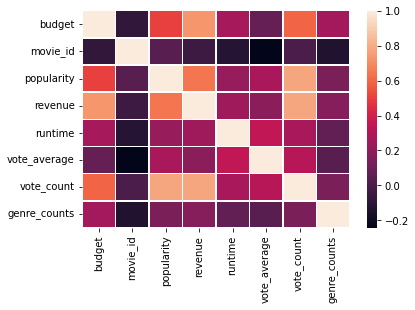

In [ ]:
#Visualize the correlation between features
corr = tmdb_attributes_df.corr()
sns.heatmap(corr, linewidths=.5)

## Machine Learning - Classification


###Import ML libraries.
###sklearn is the workhorse ML package in Python

In [ ]:
# Import LabelEncoder for converting categorical variables into numerical (dummy) variables
from sklearn import preprocessing as prep

#Import train_test_split function
from sklearn.model_selection import train_test_split

#Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

### Split the data into predictors and outcome

### Split dataset into training set and test set

Note that here we are choosing 70% of the data to train the model and 30% of the data to test the model. Later on, you will see how changing this parameter affects the model performance.

### Insert your models....